##### Sensitivity Analysis Results of the effect of Energy Producer Maximum outPut on the Voltage Rise Detected 

Simulation are done in [SensAnalysisP0100](SensAnalysisP0100.ipynb) 
* Prediction block RNN trained in [RNN_Train_StLaurentDeJourdes](RNN_Train_StLaurentDeJourdes.ipynb) 
* Robust RNN To predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ based on Combined robust Model1 and Model 3 [2021_2022_RNN_Robust_All_Models](2021_2022_RNN_Robust_All_Models.ipynb))
* Prediction Block Future Known [2021_2022_KnownFuture](2021_2022_KnownFuture.ipynb)
* Persistence Model [2021_2022_Persistence](2021_2022_Persistence.ipynb)



Maximum voltage rise $vm_{pu}^{max} = 1.0250 $

---

#### Import Modules 


In [1]:
import pandas as pd
# import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pickle, sys, importlib
import joblib

##### My own modules and functions

In [3]:
# import psutil
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriVariables import (Δt, 
                          pd_Δt,
                          defAuth_hvBus_vRiseMax,
                          default_ctrld_hvProd_max, 
                          ctrld_HvProd_name, 
                          simResult_folder)

#### Import Simulation results from Simumlation done in [SensAnalysisP0100](SensAnalysisP0100.ipynb) 

In [ ]:
fut_known = joblib.load(f'{simResult_folder}SensAnalysis{ctrld_HvProd_name}_FutureKnown.pkl')
rnn_pred  = joblib.load(f'{simResult_folder}SensAnalysis{ctrld_HvProd_name}_RNN.pkl')
rnnCombRob1_pred = joblib.load(f'{simResult_folder}SensAnalysis{ctrld_HvProd_name}_RNN_Robust_Model1.pkl')
rnnCombRob3_pred = joblib.load(f'{simResult_folder}SensAnalysis{ctrld_HvProd_name}_RNN_Robust_Model3.pkl')
persRob_pred = joblib.load(f'{simResult_folder}SensAnalysis{ctrld_HvProd_name}_PersRob.pkl')

#### Simulation results Data Reshaping

##### Declare variables to use later

In [6]:
str_powerSgen  = 'Power Sgen'
str_noControl = 'No_Control'

ctrldHvProd_output_var_step = 0.2   # (MW) Controlled HV Prod output variation step 
ctrld_hvProd_max_range = np.arange(0, default_ctrld_hvProd_max+0.1 ,ctrldHvProd_output_var_step)

model_names = ['Future known',
               'RNN Model1',
               'RNN Model1 CombRob',
               'RNN Model3 CombRob',
               'Persistence Rob']

##### Create daily mask

In [5]:
int_var = fut_known['Sim1'][str_powerSgen]
mask = int_var.index.to_timestamp().to_series().between_time('08:10','18:30').index.to_period(pd_Δt)

##### Create list of prediction for each model

In [6]:
# Get all the models in a list
models_list = [fut_known, 
               rnn_pred, 
               rnnCombRob1_pred, 
               rnnCombRob3_pred, 
               persRob_pred]


comb_list , comb_list_event = [],[] 

##### For each model create a list for the interest variables (Energy and voltage rise)

In [7]:
# for each models considered Create a list for each variable  (Energy and voltage rise) we're interested in 
fut_known_energyList, fut_known_vRiseList = [], []
rnn_pred_energyList, rnn_pred_vRiseList = [], []
rnnCombRob1_pred_energyList, rnnCombRob1_pred_vRiseList = [], []
rnnCombRob3_pred_energyList, rnnCombRob3_pred_vRiseList = [], []
persRob_pred_energyList, persRob_pred_vRiseList = [], []


# Collect all the same type of variable in a list
models_energyList = [fut_known_energyList, 
                        rnn_pred_energyList, 
                        rnnCombRob1_pred_energyList, 
                        rnnCombRob3_pred_energyList, 
                        persRob_pred_energyList]

models_vRiseList = [fut_known_vRiseList, 
                    rnn_pred_vRiseList, 
                    rnnCombRob1_pred_vRiseList, 
                    rnnCombRob3_pred_vRiseList, 
                    persRob_pred_vRiseList ]

##### Extract data for simulation for each model

In [8]:
for cur_sim in list(fut_known.keys())[1:]:  # For each simulation ['Sim2', 'Sim3' .... , 'Sim20']
                                            # We discard the first simulation since its ctrdHv_prod
                                            # is null. 
    nb_events = [] # " Intermediate variables"
    energy_inj_list = []
    
    # Get the power of ctrlHv_prod when no control is applied for each instant for the current simulation
    power_inj_noControl_curSim =  fut_known[cur_sim][str_powerSgen].loc[mask, str_noControl]
    
    for cur_indx, cur_model in enumerate(models_list):  # For each model to consider
        
        # Extract Energy variables for the current model 
        energy_inj_noControl, energy_injCurModel = cur_model[cur_sim][str_powerSgen].loc[mask].sum()*Δt 
        
        # Add variables to the associated List
        models_energyList[cur_indx].append([energy_inj_noControl, 
                                            energy_injCurModel, 
                                            energy_injCurModel*100/energy_inj_noControl])
                
        # Save The total Energy injected  for the  current model
        energy_inj_list.append(energy_injCurModel)
        
        # Substract the no controlled power of ctrlHv_prod from the controlled  with the current model 
        # to get positive values 
        var2 = power_inj_noControl_curSim - cur_model[cur_sim][str_powerSgen].loc[mask].iloc[:,-1]
        
        # Save the total number of instants where the power with no control > to that of the current predictor
        nb_events.append((var2>0).sum())

        
        if cur_indx != 0 : # Ignore the first index, that of the future known simulation
            vRise_curSim_curModel = cur_model[cur_sim]['maxV_rise_df'].loc[mask]
            
            # extract in the vRise_curSim_curModel the df of instants where the vRise > defAuth_hvBus_vRiseMax
            vRise_thresholded = vRise_curSim_curModel.query(f'{vRise_curSim_curModel.columns[0]}>@defAuth_hvBus_vRiseMax')
            
            models_vRiseList[cur_indx].append(vRise_thresholded) # Add to the concerned list

    # Add element to list for the current simulation
    comb_list_event.append(nb_events) 
    comb_list.append([energy_inj_noControl-energy_inj_curSim for energy_inj_curSim in energy_inj_list])

#### Show energy for each model (MWh) depending on the Simulation number

Note that the last simulation numbers depends on the `len(ctrld_hvProd_max_range)` declared in [SensAnalysisP0100](SensAnalysisP0100.ipynb). Here it is 21 included

In [9]:
sim_number = 19  # Range from 0 to 19 included. 
print('                     No_Control   Cur Model   Percentage \n' 
      '--------------------------------------------------------')
for mod_index, mod_name in enumerate(model_names):
    # variable = str(np.round(models_energyList[mod_index][sim_number], decimals=4))
    var = models_energyList[mod_index][sim_number]
    print(f'{mod_name:>18}    {var[0]:>9.3f}   {var[1]:>9.3f}  {var[2]:>9.3f}')

                     No_Control   Cur Model   Percentage 
--------------------------------------------------------
      Future known     5060.710    4704.868     92.969
        RNN Model1     5060.710    4442.249     87.779
RNN Model1 CombRob     5060.710    4755.335     93.966
RNN Model3 CombRob     5060.710    4734.939     93.563
   Persistence Rob     5060.710    4724.883     93.364


#### Plot Variation of the yearly curtailed energy function of  ctrlHv_prod output

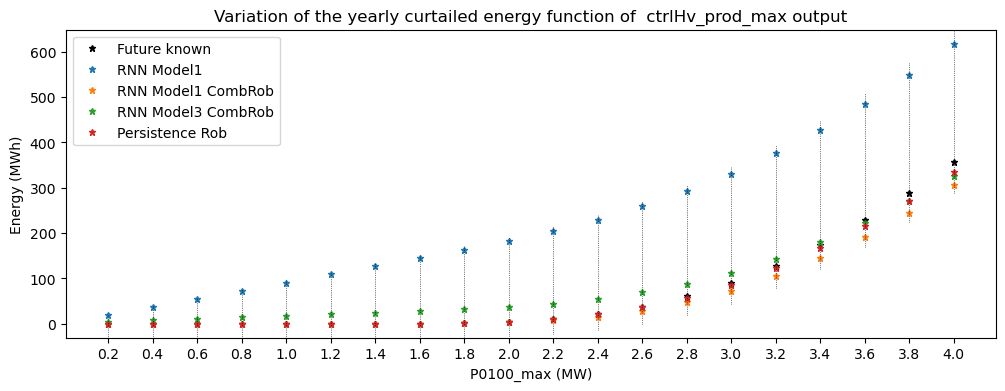

In [11]:
color_list = ['k', 'tab:blue', 'tab:orange','tab:green', 'tab:red']

# ctrlHv_prod_maxRange = np.round(ctrlHv_prod_max_range[1:], decimals=2) # Create range for each value of ctrlHv_prod_max

fig, axx = plt.subplots(1, figsize=(12,4))
for elm in range(np.array(comb_list).shape[1]): 
    axx.plot(np.array(comb_list)[:,elm].round(decimals=3), ls='', marker='*', markersize=5,color=color_list[elm])
    
plt.xticks(range(20), labels=np.round(ctrld_hvProd_max_range[1:], decimals=2), rotation=0);
var = np.array(comb_list).round(decimals=3)
axx.get_facecolor
axx.set(ylabel = 'Energy (MWh)', xlabel = f'{ctrld_HvProd_name}_max (MW)')
axx.set_title("Variation of the yearly curtailed energy function of  ctrlHv_prod_max output")


for rows in range(20):
    axx.axvline(x=axx.get_xticks()[rows], 
                ymin= var[rows].min()/(axx.get_ylim()[1]), 
                ymax=0.046+var[rows].max()/axx.get_ylim()[1], lw=0.5, color='k', ls=':')

plt.legend(model_names)

#### Plot Total number of Capping command function of the   ctrlHv_prod output

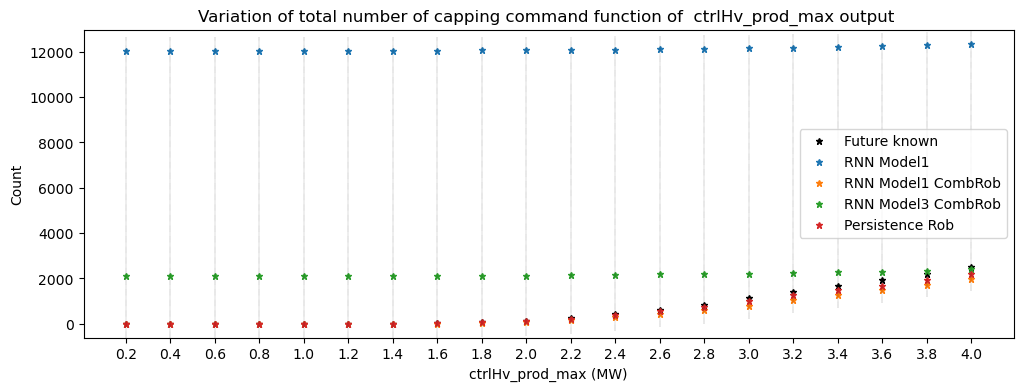

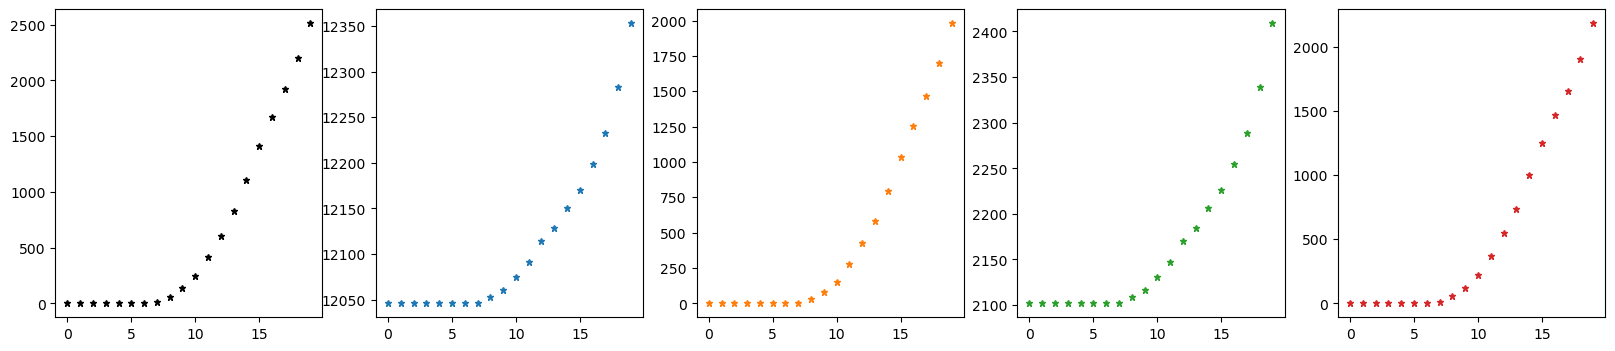

In [12]:
color_list = ['k', 'tab:blue', 'tab:orange','tab:green', 'tab:red']

xticks_range = range(len(ctrld_hvProd_max_range)-1);


fig, axx = plt.subplots(1, figsize=(12,4))
for elm in range(np.array(comb_list_event).shape[1]): 
    axx.plot(np.array(comb_list_event)[:,elm].round(decimals=3), ls='', marker='*', markersize=5,color=color_list[elm])
    
plt.xticks((xticks_range), labels=np.round(ctrld_hvProd_max_range[1:], decimals=2), rotation=0);
var = np.array(comb_list_event).round(decimals=3)
axx.get_facecolor
axx.set(ylabel = 'Count', xlabel = 'ctrlHv_prod_max (MW)')
axx.set_title("Variation of total number of capping command function of  ctrlHv_prod_max output ")

for rows in xticks_range:
    axx.axvline(x=axx.get_xticks()[rows], 
                ymin= var[rows].min()/(axx.get_ylim()[1]), 
                ymax=0.046+var[rows].max()/axx.get_ylim()[1], lw=0.3, color='k', ls=':')

plt.legend(model_names)



fig, axx = plt.subplots(1,5, figsize=(20,4))
for elm, cur_ax in zip(range(np.array(comb_list_event).shape[1]), axx.flatten()): 
    cur_ax.plot(np.array(comb_list_event)[:,elm].round(decimals=2), ls='', marker='*', markersize=5,color=color_list[elm])

# fig.legend(model_names, bbox_to_anchor=(0.22,0.8))

##### How can one explain the behavior of the RNN_Mod3_Rob
It is important to notice that the Robust RNN model 3 which predicts voltage rise values has been trained with data provided by ctrlHv_prod_max = 4MWh. We assume that the parameters learn in this specific training case do not generalize for lower values of ctrlHv_prod_max which could explain why the total number of capping command is higher than that of the other controller

<div class = 'alert alert-block alert-info' >
<b> TODO:</b>
    Train a new RNN for each ctrlHv_prod_max
</div>

#### Reshape data into dataframe to do a categorical Plot

In [13]:
df2usev= pd.DataFrame(columns=['V_rise','Model', 'Power']) # Create empty dataframe with following collumns
p0100_maxRange = np.round(ctrld_hvProd_max_range[1:], decimals=2)

for cur_models_ind in range(1,5): # For the current model_index
    for p_max_ind in range(20): # For each value of P0100_max
        
        # Create a dataframe of voltage rise
        df = pd.DataFrame(models_vRiseList[cur_models_ind][p_max_ind].dropna().values, columns=['V_rise'])
        
        # Add to the previously created dataframe columns ['Model', 'Power'] based on the model name and P0100's power
        df[['Model', 'Power']] = model_names[cur_models_ind], p0100_maxRange[p_max_ind]
        
        df2usev = pd.concat([df2usev, df]) # Concatanate created dataframe with the exsisting dataframe

        
        
# Add values for the No control model to the previous created dataframe        
for cur_index, cur_sim in enumerate(list(fut_known.keys())[1:]): 
    # Extract values of voltage rise when no control and apply mask to.
    var = fut_known[cur_sim]['maxV_rise_pf_df'].loc[mask]
    
    # Create a dataframe using the thresholded values of the precedend var
    df = pd.DataFrame(var[var>1.025].dropna().values, columns=['V_rise'])
    
    # Add to the previously created dataframe columns ['Model', 'Power'] based on the model name and P0100's power
    df[['Model', 'Power']] = 'No_Control', p0100_maxRange[cur_index]
    
    df2usev = pd.concat([df2usev, df]) # Concatanate created dataframe with the exsisting dataframe
    

#### Plot Categorical data

<span style='color:red'> See boxplots [Figure](https://www.researchgate.net/publication/340996565/figure/fig3/AS:962186885210119@1606414638167/Box-plot-and-probability-density-function-of-a-normal-distribution.png) </span>




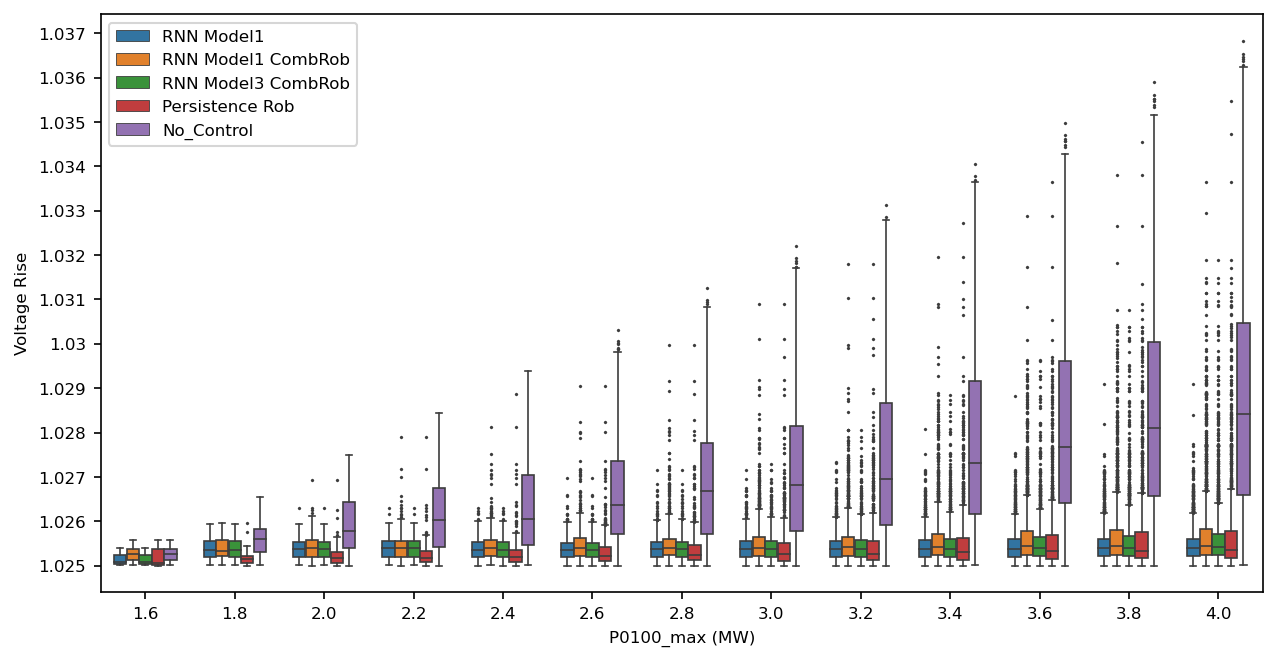

In [14]:
flprop = dict(marker='x',)
fig, axx = plt.subplots(figsize=(10,5), dpi=150)
sbn.boxplot(x='Power', y='V_rise', data=df2usev, hue='Model', width=0.7, fliersize=1,linewidth=0.8, 
            flierprops=flprop, 
            
           )
lblsize = 8 
axx.set_xlabel(f'{ctrld_HvProd_name}_max (MW)', size=lblsize )
axx.set_ylabel('Voltage Rise', size=lblsize )
axx.set_xticklabels(p0100_maxRange[7:],size=lblsize )
axx.set_yticks(ticks=np.arange(1.025,1.037,0.001),
               labels=np.round(np.arange(1.025,1.037,0.001), decimals=3), size=lblsize)
axx.legend(fontsize=lblsize)

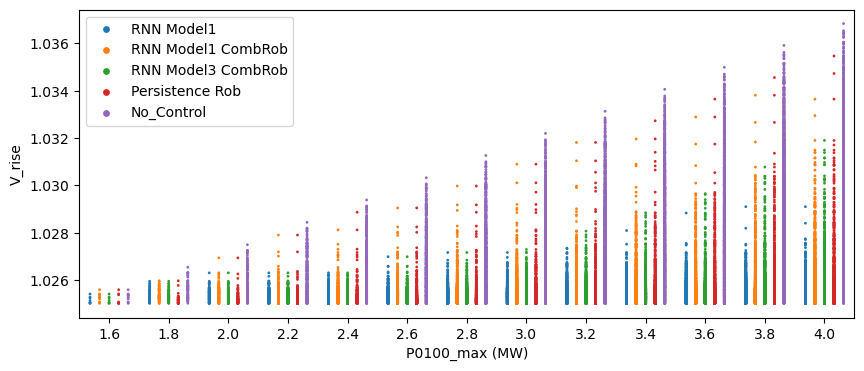

In [15]:
fig, axx = plt.subplots(figsize=(10,4), dpi=100)
sbn.stripplot(x='Power', y='V_rise', data=df2usev, hue='Model',ax=axx, size=2,  dodge=True,jitter=False)
axx.set( xlabel = f'{ctrld_HvProd_name}_max (MW)')
axx.legend(markerscale=0.5)

#### Get the Total number of event where the voltage rise is above defined threshold for each model

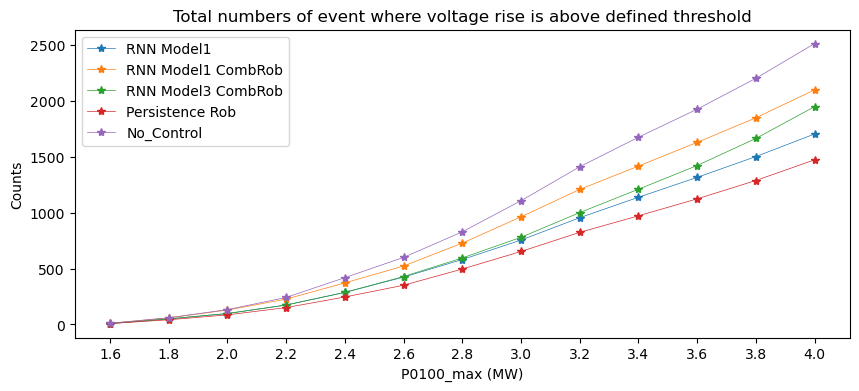

In [16]:
aa = pd.concat([df2usev.groupby(by=['Model', 'Power']).count().T[mod_name] for mod_name in df2usev.Model.unique()])
aa.index = df2usev.Model.unique()

fig, axx = plt.subplots(figsize=(10,4), dpi=100)
aa.T.plot(marker='*', lw=0.5, ax= axx)
plt.xticks(np.arange(1.6,4.1,0.2))
axx.set(xlabel=f'{ctrld_HvProd_name}_max (MW)', ylabel='Counts', title='Total numbers of event where voltage rise is above defined threshold');